In [ ]:
# Multi-Modal Transport Optimization: Per-Segment Mode Classification (XGBoost)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from itertools import product


In [ ]:
df = pd.read_excel("trainingtestingset_latest.xlsx")
df.head()


,id,taxi_AB,bus_AB,bike_AB,taxi_BC,bus_BC,bike_BC,taxi_CD,bus_CD,bike_CD,traffic_AB,traffic_BC,traffic_CD
0,0,15,15,10,7,13,11,12,20,13,1,2,1
1,1,8,12,15,15,11,12,8,11,9,1,2,2
2,2,12,13,17,8,20,12,7,17,13,2,2,2
3,3,6,17,16,13,10,14,14,18,16,1,2,2
4,4,8,15,9,9,12,8,12,10,15,1,1,2


In [ ]:
# Determine best mode combination (minimize total travel time)
def find_best_mode_combo(row):
    min_time = float('inf')
    best_combo = None
    for combo in product(['taxi', 'bus', 'bike'], repeat=3):
        total_time = (
            row[f'{combo[0]}_AB'] +
            row[f'{combo[1]}_BC'] +
            row[f'{combo[2]}_CD']
        )
        if total_time < min_time:
            min_time = total_time
            best_combo = combo
    return '->'.join(best_combo)

In [ ]:
df['best_combo'] = df.apply(find_best_mode_combo, axis=1)

# Extract per-segment labels
df[['mode_AB', 'mode_BC', 'mode_CD']] = df['best_combo'].str.split('->', expand=True)

In [ ]:
# Features and labels
features = [
    'taxi_AB', 'bus_AB', 'bike_AB',
    'taxi_BC', 'bus_BC', 'bike_BC',
    'taxi_CD', 'bus_CD', 'bike_CD',
    'traffic_AB', 'traffic_BC', 'traffic_CD'
]
X = df[features]
y_AB = df['mode_AB']
y_BC = df['mode_BC']
y_CD = df['mode_CD']

In [ ]:
# Split train/test for each segment
X_train, X_test, y_AB_train, y_AB_test = train_test_split(X, y_AB, train_size=75, random_state=42)
_, _, y_BC_train, y_BC_test = train_test_split(X, y_BC, train_size=75, random_state=42)
_, _, y_CD_train, y_CD_test = train_test_split(X, y_CD, train_size=75, random_state=42)

In [ ]:
# Encode labels
enc_AB = LabelEncoder()
enc_BC = LabelEncoder()
enc_CD = LabelEncoder()

y_AB_train_enc = enc_AB.fit_transform(y_AB_train)
y_AB_test_enc = enc_AB.transform(y_AB_test)

y_BC_train_enc = enc_BC.fit_transform(y_BC_train)
y_BC_test_enc = enc_BC.transform(y_BC_test)

y_CD_train_enc = enc_CD.fit_transform(y_CD_train)
y_CD_test_enc = enc_CD.transform(y_CD_test)

In [ ]:
# Train XGBoost classifiers
xgb_AB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_BC = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_CD = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_AB.fit(X_train, y_AB_train_enc)
xgb_BC.fit(X_train, y_BC_train_enc)
xgb_CD.fit(X_train, y_CD_train_enc)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:46:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:46:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:46:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict
y_AB_pred_xgb = xgb_AB.predict(X_test)
y_BC_pred_xgb = xgb_BC.predict(X_test)
y_CD_pred_xgb = xgb_CD.predict(X_test)

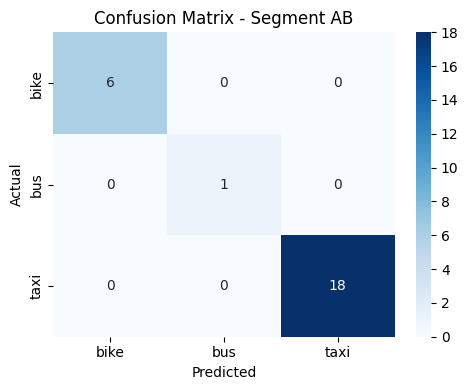

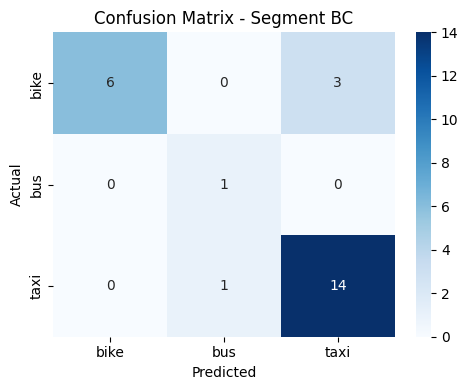

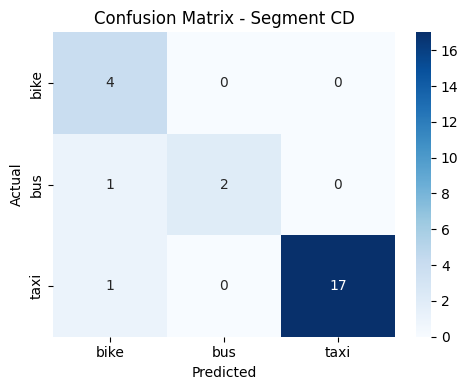

In [ ]:
# Confusion Matrices
cm_AB_xgb = confusion_matrix(y_AB_test_enc, y_AB_pred_xgb)
cm_BC_xgb = confusion_matrix(y_BC_test_enc, y_BC_pred_xgb)
cm_CD_xgb = confusion_matrix(y_CD_test_enc, y_CD_pred_xgb)

# Visualize confusion matrices
def plot_cm(cm, encoder, title):
    labels = encoder.classes_
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.tight_layout()
    plt.show()

plot_cm(cm_AB_xgb, enc_AB, "Segment AB")
plot_cm(cm_BC_xgb, enc_BC, "Segment BC")
plot_cm(cm_CD_xgb, enc_CD, "Segment CD")


In [ ]:
# Accuracy scores
acc_AB = accuracy_score(y_AB_test_enc, y_AB_pred_xgb)
acc_BC = accuracy_score(y_BC_test_enc, y_BC_pred_xgb)
acc_CD = accuracy_score(y_CD_test_enc, y_CD_pred_xgb)

print("Accuracy AB:", acc_AB)
print("Accuracy BC:", acc_BC)
print("Accuracy CD:", acc_CD)


Accuracy AB: 1.0
Accuracy BC: 0.84
Accuracy CD: 0.92
